In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

In [3]:
import numpy as np

In [4]:
from tda.experiments.lid.lid_binary import logger, run_experiment, Config, Architecture, get_feature_datasets
from tda.models.architectures import get_architecture, mnist_lenet
from tda.models import get_deep_model
from tda.models.datasets import Dataset

2020-01-27 11:42:16,123 - Devices - INFO - Found 0 compatible with CUDA


In [5]:
config = Config(
    epochs=50,
    dataset="MNIST",
    architecture=mnist_lenet.name,
    train_noise=0.0,
    nb_batches=1,
    attack_type="FGSM",
    noise=0.0,
    num_iter=1,
    batch_size=100,
    number_of_nn=20,
    successful_adv=True
)

In [6]:
dataset = Dataset(name=config.dataset)

logger.info(f"Getting deep model...")
archi: Architecture = get_deep_model(
    num_epochs=config.epochs,
    dataset=dataset,
    architecture=get_architecture(config.architecture),
    train_noise=config.train_noise
)

datasets = dict()

for epsilon in [0.01, 0.025, 0.05, 0.1, 0.4, 1.0]:
    ds_train, ds_test = get_feature_datasets(
        config=config,
        epsilon=epsilon,
        dataset=dataset,
        archi=archi
    )
    datasets[epsilon] = (ds_train, ds_test)

2020-01-27 11:42:26,328 - LID - INFO - Getting deep model...
2020-01-27 11:42:26,329 - Models - INFO - Filename = /Users/t.ricatte/dev/tda_for_adv_robustness/tda/../trained_models/mnist_mnist_lenet_50_epochs.model 

/Users/t.ricatte/dev/tda_env/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'tda.models.architectures.Architecture' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
2020-01-27 11:42:26,343 - Models - INFO - Loaded successfully model from /Users/t.ricatte/dev/tda_for_adv_robustness/tda/../trained_models/mnist_mnist_lenet_50_epochs.model
2020-01-27 11:42:26,344 - LID - INFO - Evaluating epsilon=0.01
2020-01-27 11:42:26,345 - Cache - INFO - Using cache file /Users/t.ricatte/dev/tda_for_adv_robustness/tda/../cache/get_sample_dataset/adv=True_archi=m

In [7]:
datasets[0.4][0]

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,label,l2_norm,linf_norm
0,7.826012,7.121026,7.521339,6.608914,2.839315,2.839315,2.096558,0.0,0.000000,0.0
1,10.251671,8.914675,8.536477,12.468080,6.963720,6.963720,6.022425,0.0,0.000000,0.0
2,3.663839,3.571638,3.363593,2.569572,1.369712,1.369712,0.971590,0.0,0.000000,0.0
3,12.664940,11.539657,6.575437,6.070586,2.134655,2.134655,1.535897,0.0,0.000000,0.0
4,9.886588,8.821885,9.577665,8.738871,5.108611,5.108611,3.757313,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
95,22.960194,27.353845,24.196995,17.968025,4.756369,4.756369,2.719742,1.0,7.915897,0.4
96,15.618919,15.243097,13.326799,12.473205,6.599398,6.599398,6.050702,1.0,8.151682,0.4
97,19.971228,22.046868,19.655430,22.275224,6.181584,6.181584,4.351380,1.0,8.260038,0.4
98,20.321736,18.350342,14.424089,14.124101,4.361164,4.361164,2.813762,1.0,8.119847,0.4


In [8]:
linfs = dict()
l2s = dict()

for key in datasets:
    linf_mean_train = datasets[key][0].query("label > 0").linf_norm.mean()
    l2_mean_train = datasets[key][0].query("label > 0").l2_norm.mean()
    
    linfs[key] = linf_mean_train
    l2s[key] = l2_mean_train

## Supervised Learning

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

scaler = StandardScaler()

all_aucs = dict()
all_coefs = dict()

for epsilon in datasets:
    train_ds, test_ds = datasets[epsilon]
    
    detector = LogisticRegression(
        fit_intercept=True,
        verbose=1,
        tol=1e-5,
        max_iter=1000,
        solver='lbfgs'
    )
    
    ds_train_scaled = scaler.fit_transform(train_ds.iloc[:, :-3])

    detector.fit(X=ds_train_scaled, y=train_ds.iloc[:, -3])
    coefs = list(detector.coef_.flatten())
    logger.info(f"Coefs of detector {coefs}")
    
    ds_test_scaled = scaler.transform(test_ds.iloc[:, :-3])

    test_predictions = detector.predict_proba(X=ds_test_scaled)[:, 1]
    auc = roc_auc_score(y_true=test_ds.iloc[:, -3], y_score=test_predictions)
    logger.info(f"AUC is {auc}")

    all_aucs[epsilon] = auc
    all_coefs[epsilon] = coefs

logger.info(all_aucs)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
2020-01-27 11:46:10,975 - LID - INFO - Coefs of detector [0.3110343307338925, -0.4428972441429085, 0.7039780198277789, -0.4409024033579074, -0.1317253953735625, -0.1317253953735625, 1.8573415294970357]
2020-01-27 11:46:10,978 - LID - INFO - AUC is 0.852
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
2020-01-27 11:46:10,988 - LID - INFO - Coefs of detector [0.10514472424045432, -0.14884192464198778, 0.5409148669104138, 0.17097672532388625, 0.5372741438360037, 0.5372741438360037, 0.810750767100637]
2020-01-27 11:46:10,992 - LID - INFO - AUC is 0.7867999999999999
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
2020-01-27 11:46:11,001 - L

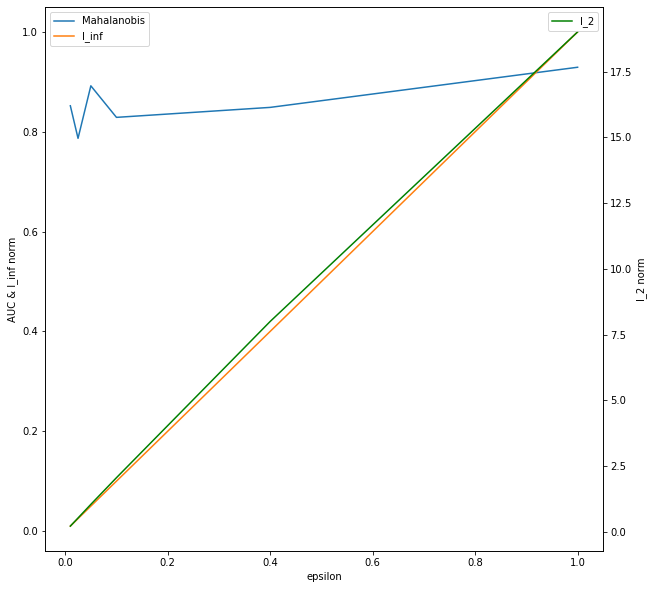

In [18]:
keys = sorted(all_aucs.keys())
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

fig, ax1 = plt.subplots()

ax1.set_xlabel('epsilon')
ax1.set_ylabel('AUC & l_inf norm')
#plt.xscale('log')
ax1.plot(
    keys, [all_aucs[k] for k in keys], label="Mahalanobis"
)
ax1.plot(
    keys, [linfs[k] for k in keys], label="l_inf"
)

ax2 = ax1.twinx()
ax2.set_ylabel("l_2 norm")

ax2.plot(
    keys, [l2s[k] for k in keys], label="l_2", color="green"
)

ax1.legend()
ax2.legend()

## Unsupervised Learning

In [19]:
from sklearn.svm import OneClassSVM

scaler = StandardScaler()

aucs = dict()
coefs = dict() 

for key in datasets:
    
    ds_train, ds_test = datasets[key]
    
    detector = OneClassSVM(
        tol=1e-5,
        kernel='rbf',
        nu=1e-4
    )
        
    ds_train_scaled = scaler.fit_transform(ds_train.iloc[:, :-3])

    detector.fit(X=ds_train_scaled)
    #coef = list(detector.coef_.flatten())
    #logger.info(f"Coefs of detector {coef}")
    #logger.info(f"Intercept of detector {detector.intercept_}")
    
    ds_test_scaled = scaler.transform(ds_train.iloc[:, :-3])
    
    train_predictions = detector.decision_function(X=ds_train_scaled)
    
    test_predictions = detector.decision_function(X=ds_test_scaled)
    logger.info(f"Average prediction {np.mean(test_predictions)}")
    auc = roc_auc_score(y_true=ds_test.iloc[:, -3], y_score=test_predictions)
    
    logger.info(f"AUC for {key} => {auc}")

    aucs[key] = auc
    #coefs[key] = coef
    
logger.info(f"All AUCS are {aucs}")

2020-01-27 11:47:21,194 - LID - INFO - Average prediction 0.00015127432683210843
2020-01-27 11:47:21,197 - LID - INFO - AUC for 0.01 => 0.5776
2020-01-27 11:47:21,202 - LID - INFO - Average prediction 7.357282871113856e-05
2020-01-27 11:47:21,205 - LID - INFO - AUC for 0.025 => 0.48160000000000003
2020-01-27 11:47:21,210 - LID - INFO - Average prediction 9.690872745665969e-05
2020-01-27 11:47:21,212 - LID - INFO - AUC for 0.05 => 0.5404
2020-01-27 11:47:21,217 - LID - INFO - Average prediction 0.0001443514654231692
2020-01-27 11:47:21,219 - LID - INFO - AUC for 0.1 => 0.6220000000000001
2020-01-27 11:47:21,224 - LID - INFO - Average prediction 0.0001934935561623504
2020-01-27 11:47:21,226 - LID - INFO - AUC for 0.4 => 0.6440000000000001
2020-01-27 11:47:21,231 - LID - INFO - Average prediction 0.00013607805616364327
2020-01-27 11:47:21,234 - LID - INFO - AUC for 1.0 => 0.5224
2020-01-27 11:47:21,235 - LID - INFO - All AUCS are {0.01: 0.5776, 0.025: 0.48160000000000003, 0.05: 0.5404, 0.

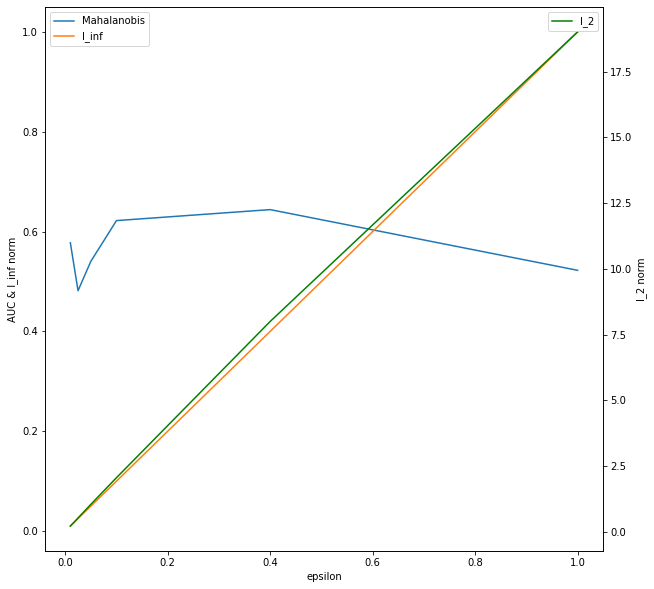

In [20]:
keys = sorted(aucs.keys())
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

fig, ax1 = plt.subplots()

ax1.set_xlabel('epsilon')
ax1.set_ylabel('AUC & l_inf norm')
#plt.xscale('log')
ax1.plot(
    keys, [aucs[k] for k in keys], label="Mahalanobis"
)
ax1.plot(
    keys, [linfs[k] for k in keys], label="l_inf"
)

ax2 = ax1.twinx()
ax2.set_ylabel("l_2 norm")

ax2.plot(
    keys, [l2s[k] for k in keys], label="l_2", color="green"
)

ax1.legend()
ax2.legend()